# Car price prediction

## Get data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time


from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### conclusions on data

A lot of missing values in VehicleType, GearBox, Model, FuelType


## Analyse data

In [6]:
def plot_hist_box(data, column_name):
    # Create a figure with two subplots (histogram and box plot)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Histogram
    axes[0].hist(data[column_name], bins=50, color='blue', alpha=0.7)
    axes[0].set_title(f'Histogram of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')

    # Box plot
    axes[1].boxplot(data[column_name], vert=False)
    axes[1].set_title(f'Box Plot of {column_name}')
    axes[1].set_xlabel(column_name)

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

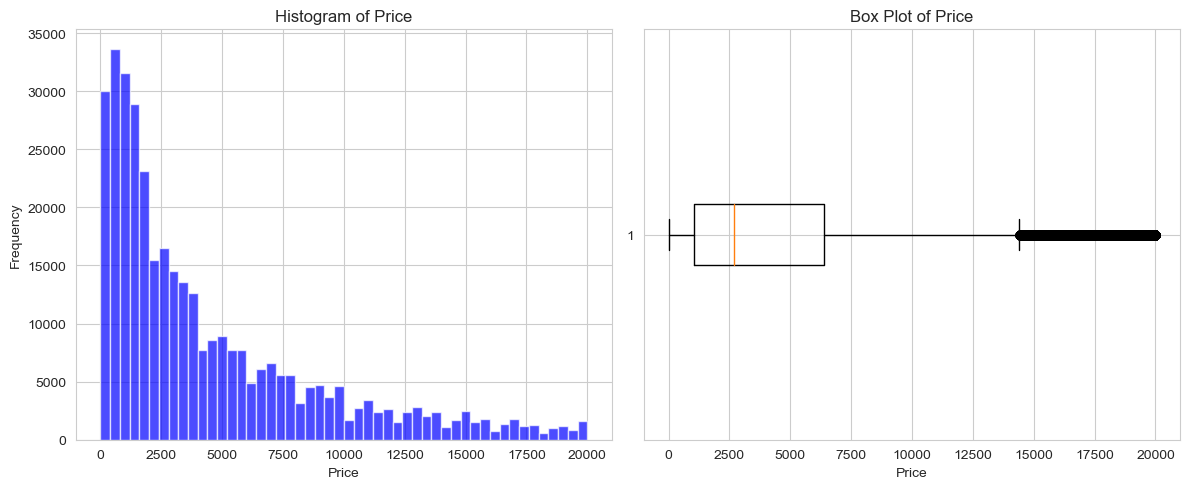

In [7]:
plot_hist_box(data, 'Price')

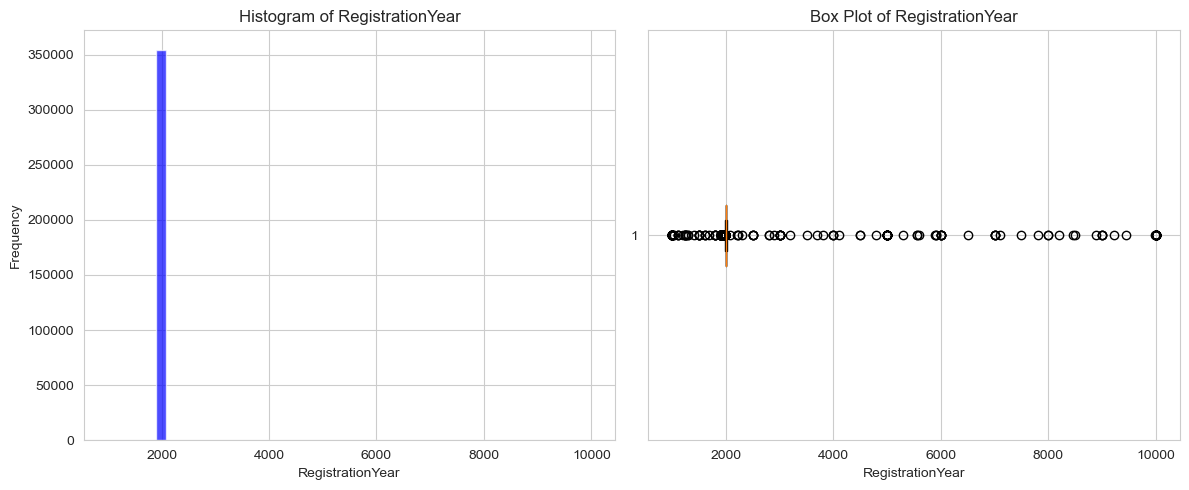

<AxesSubplot:>

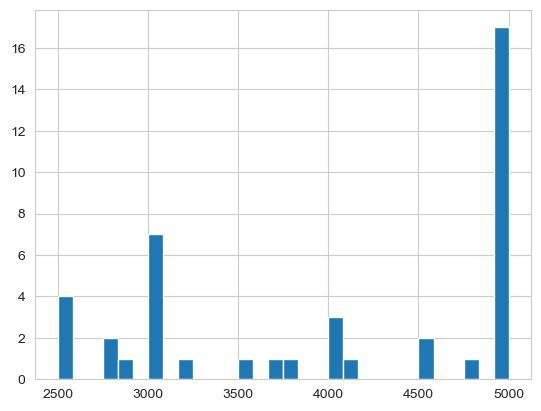

In [8]:
plot_hist_box(data, 'RegistrationYear')
data['RegistrationYear'].hist(bins=30, range=(2500, 5000))

<AxesSubplot:>

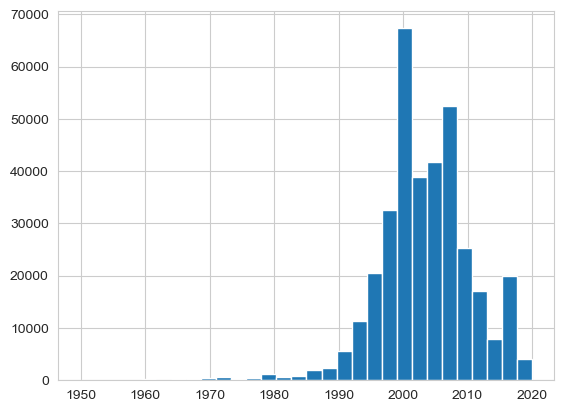

In [9]:
data['RegistrationYear'].hist(bins=30, range=(1950, 2020))

We can see that we have a few outliers that have values (year of registration) are not correct. We keep that in mind.

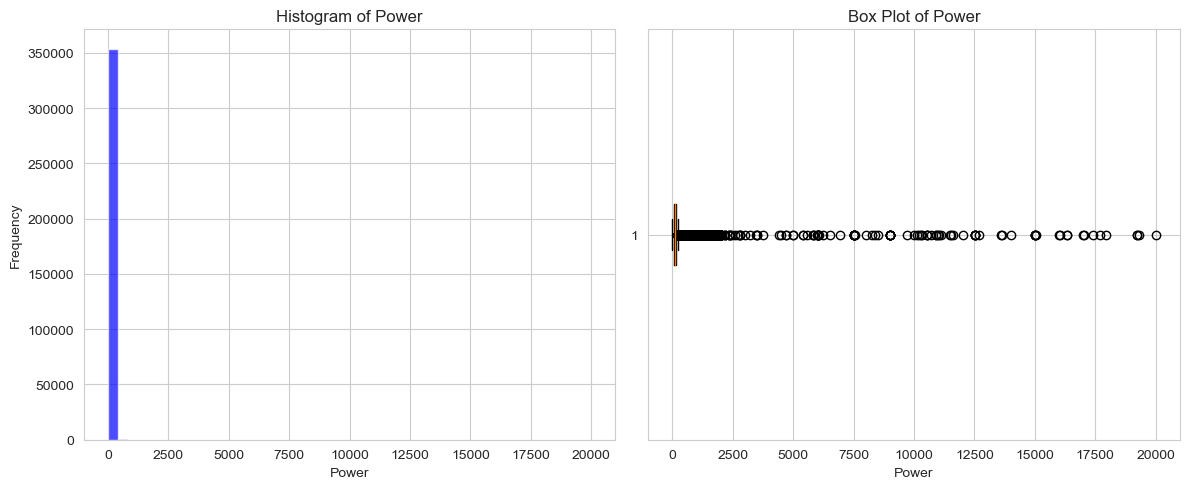

<AxesSubplot:>

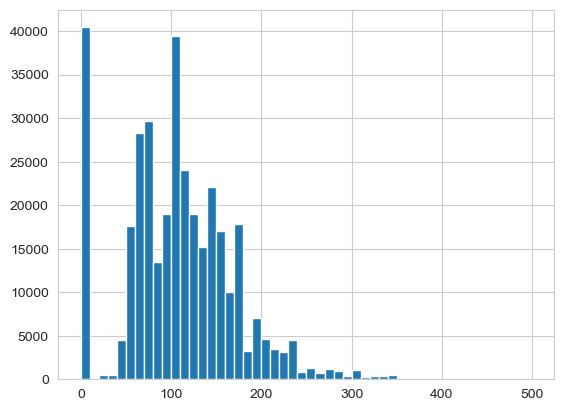

In [10]:
plot_hist_box(data, 'Power')
data['Power'].hist(bins=50, range=(0, 500))

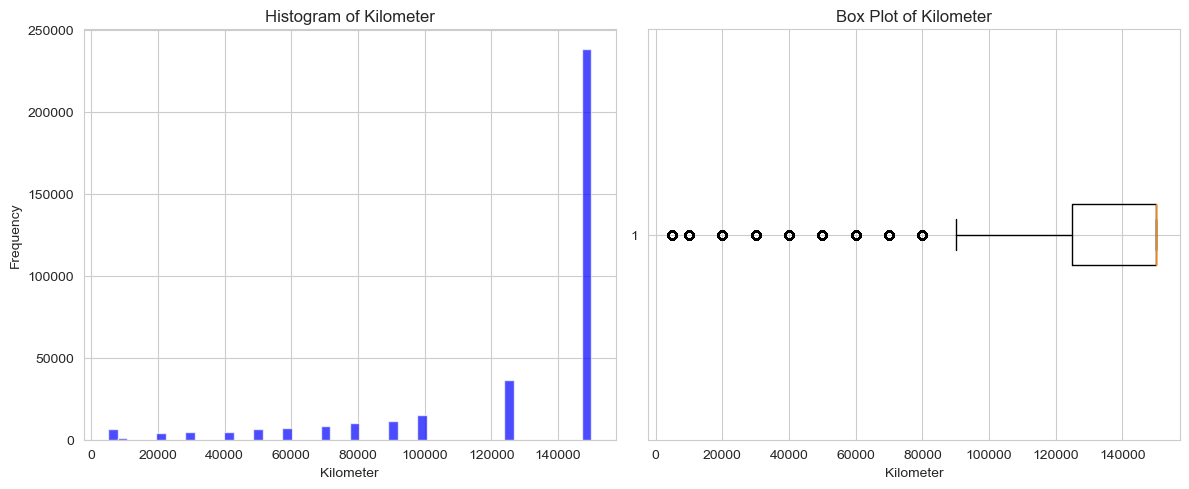

In [11]:
plot_hist_box(data, 'Kilometer')

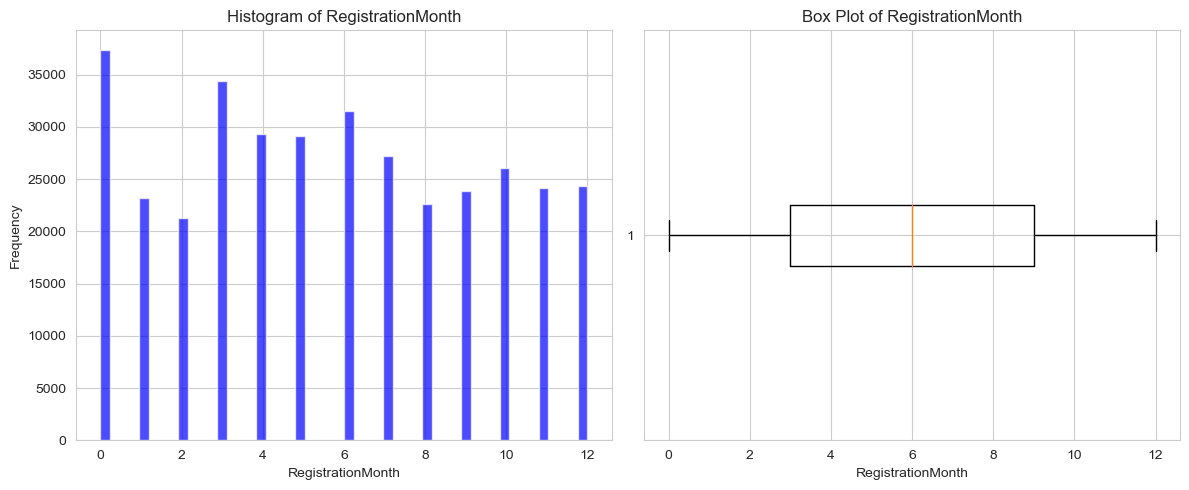

In [12]:
plot_hist_box(data, 'RegistrationMonth')

### Conclusions:
We have outliers in our data. Delete the most outrage ones. Also Considering applying QuantileTransformer in our pipeline to get the most out of our data to avoid outliers.

In [13]:
data = data.loc[(data['RegistrationYear']>1950) & (data['RegistrationYear']<2016)]
data.shape

(329976, 16)

In [14]:
data = data.loc[data['Price']>1]
data.shape

(319610, 16)

In [15]:
data = data.loc[(data['Power']<500) & (data['Power'] != 0)]
data.shape

(289437, 16)

In [16]:
data = data.drop_duplicates()
data.shape

(289433, 16)

In [17]:
data['Brand'].value_counts().head(25)

volkswagen        62214
bmw               31758
opel              31483
mercedes_benz     26873
audi              25134
ford              20148
renault           13538
peugeot            9198
fiat               7466
seat               5697
skoda              4882
mazda              4613
smart              4412
citroen            4160
nissan             3965
toyota             3954
hyundai            3065
mini               2935
volvo              2786
mitsubishi         2424
honda              2302
kia                2052
alfa_romeo         1930
suzuki             1914
sonstige_autos     1803
Name: Brand, dtype: int64

In [18]:
top_25_brand = data['Brand'].value_counts().head(25).index.tolist()
data = pd.DataFrame(data[data['Brand'].isin(top_25_brand)])

data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [19]:
data["Model"].value_counts().head(60)

golf           23839
other          17495
3er            17120
polo           10347
corsa           9785
astra           8819
a4              8701
passat          8654
c_klasse        7243
5er             7035
e_klasse        5869
a3              5066
focus           4936
a6              4902
fiesta          4669
2_reihe         4284
transporter     4068
fortwo          3749
twingo          3604
vectra          3363
a_klasse        3307
1er             3268
mondeo          2971
3_reihe         2919
touran          2857
clio            2759
punto           2538
zafira          2448
megane          2310
ibiza           2273
lupo            2076
ka              1989
octavia         1907
fabia           1852
cooper          1811
clk             1595
x_reihe         1417
micra           1351
caddy           1272
80              1259
leon            1166
sharan          1148
i_reihe         1147
omega           1140
slk             1125
laguna          1097
6_reihe         1093
scenic       

In [20]:
top_70_model = data['Model'].value_counts().head(70).index.tolist()
data = pd.DataFrame(data[data['Model'].isin(top_70_model)])

data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


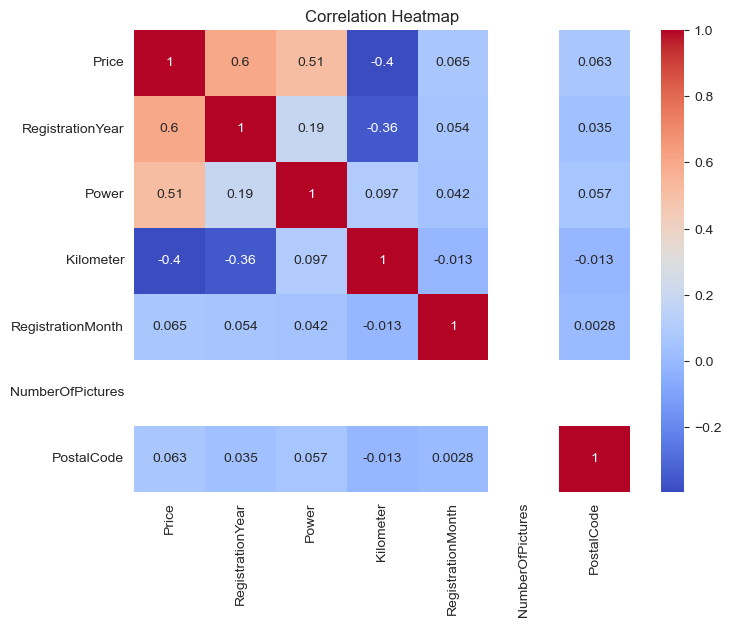

In [21]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Making Models

In [22]:
#drop unnecessary columns
X = data.drop(['DateCrawled', 'Price', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1)
y = data['Price']

In [23]:
cat_columns = ['VehicleType','Gearbox','Model','RegistrationMonth', 'FuelType', 'Brand', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']
columns = cat_columns + num_columns

In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (176038, 10)
Shape of X_test: (58680, 10)
Shape of y_train: (176038,)
Shape of y_test: (58680,)


In [25]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="Nan")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numeric_transformer = Pipeline(steps=[
    ('quantile', QuantileTransformer()),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_columns,),
    ('num', numeric_transformer, num_columns,)
])

In [26]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [27]:
linear = LinearRegression()
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear)
])

In [28]:
# create df for analysis
results_df = pd.DataFrame(columns=['Model', 'RMSE', 'Time to Fit', 'Time to Predict'])

def evaluate_model_with_pipeline(pipeline,name, X_train, y_train, X_test, y_test, results_df):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Measure time to fit the pipeline
        start_time_fit = time.time()
        pipeline.fit(X_train, y_train)
        end_time_fit = time.time()

        # Calculate RMSE
        start_time_predict = time.time()
        predictions = pipeline.predict(X_test)
        end_time_predict = time.time()
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmse_scores.append(rmse)

        # Calculate time to fit
        time_fit = end_time_fit - start_time_fit

    # Measure time to predict using the fitted pipeline
    time_predict = end_time_predict - start_time_predict

    # Add information to the results DataFrame
    results_df = results_df.append({
        'Model': name,
        'RMSE': rmse,
        'Time to Fit': time_fit,
        'Time to Predict': time_predict
    }, ignore_index=True)

    return results_df

In [29]:
mdata = evaluate_model_with_pipeline(linear_pipeline, 'LinearRegression', X_train, y_train, X_test, y_test,results_df)
mdata

/var/folders/gh/ycp1_w4n7ws8z82zzcg04g180000gn/T/ipykernel_2289/2889015297.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


,Model,RMSE,Time to Fit,Time to Predict
0,LinearRegression,2356.059565,1.766957,0.156314


In [30]:
# Define models with hyperparameter grids for RandomizedSearchCV
decision_tree_model = DecisionTreeRegressor(random_state=42, max_depth=20)

decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', decision_tree_model)
])
#results_df = evaluate_model_with_pipeline(decision_tree_pipeline,X_train,y_train,X_test,y_test, results_df)
mdata = mdata.append(evaluate_model_with_pipeline(decision_tree_pipeline,"DecisionTreeRegression",X_train,y_train,X_test,y_test, results_df))

/var/folders/gh/ycp1_w4n7ws8z82zzcg04g180000gn/T/ipykernel_2289/2889015297.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/gh/ycp1_w4n7ws8z82zzcg04g180000gn/T/ipykernel_2289/963583573.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdata = mdata.append(evaluate_model_with_pipeline(decision_tree_pipeline,"DecisionTreeRegression",X_train,y_train,X_test,y_test, results_df))


In [31]:
mdata

,Model,RMSE,Time to Fit,Time to Predict
0,LinearRegression,2356.059565,1.766957,0.156314
0,DecisionTreeRegression,1706.165930,22.212602,0.173104


In [32]:
for column in cat_columns:
    X_train[column] = X_train[column].astype('category').cat.codes
    X_test[column] = X_test[column].astype('category').cat.codes

In [33]:
lgbm_model = LGBMRegressor(n_estimators=100)
lgbm_param_grid = {
    'num_leaves': [10, 30],
    'learning_rate': [.01,.5],
    'max_depth': [-1,5]
}

lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

lgbm_grid_search.fit(X_train,y_train)

lgbm_model_name = "Best LGBM Model"
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    (lgbm_model_name, lgbm_grid_search)
])

In [34]:
def evaluate_lgbm(pipeline, name, X_train, y_train, X_test, y_test, results_df):
    # Measure time to fit the pipeline
    start_time_fit = time.time()
    pipeline.fit(X_train, y_train)
    end_time_fit = time.time()

    # Measure time to predict using the fitted pipeline
    start_time_predict = time.time()
    predictions = pipeline.predict(X_test)
    end_time_predict = time.time()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Calculate times
    time_fit = end_time_fit - start_time_fit
    time_predict = end_time_predict - start_time_predict

    # Add information to the results DataFrame
    results_df = results_df.append({
        'Model': name,
        'RMSE': rmse,
        'Time to Fit': time_fit,
        'Time to Predict': time_predict
    }, ignore_index=True)

    return results_df

In [35]:
best_lgbm_model = lgbm_grid_search.best_estimator_

In [36]:
mdata = mdata.append(evaluate_lgbm(best_lgbm_model, "LGBMRegression",X_train,y_train,X_test,y_test, results_df))

/var/folders/gh/ycp1_w4n7ws8z82zzcg04g180000gn/T/ipykernel_2289/3587572998.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/gh/ycp1_w4n7ws8z82zzcg04g180000gn/T/ipykernel_2289/3175263115.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdata = mdata.append(evaluate_lgbm(best_lgbm_model, "LGBMRegression",X_train,y_train,X_test,y_test, results_df))


In [37]:
mdata

,Model,RMSE,Time to Fit,Time to Predict
0,LinearRegression,2356.059565,1.766957,0.156314
0,DecisionTreeRegression,1706.165930,22.212602,0.173104
0,LGBMRegression,1494.359452,1.614774,0.096244


And now we can analyse our results

## Analyse results

<Figure size 1000x600 with 0 Axes>

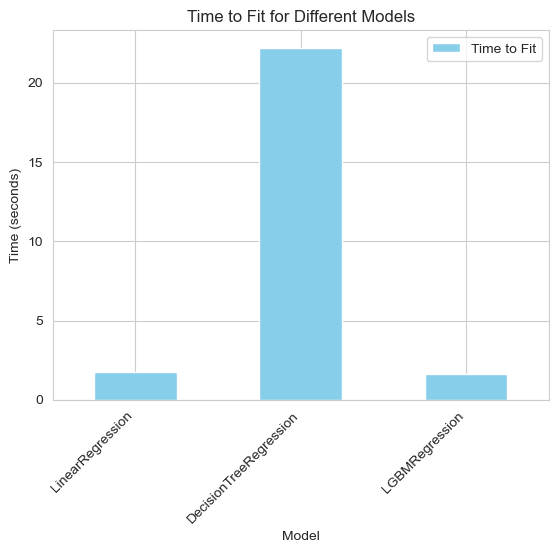

<Figure size 1000x600 with 0 Axes>

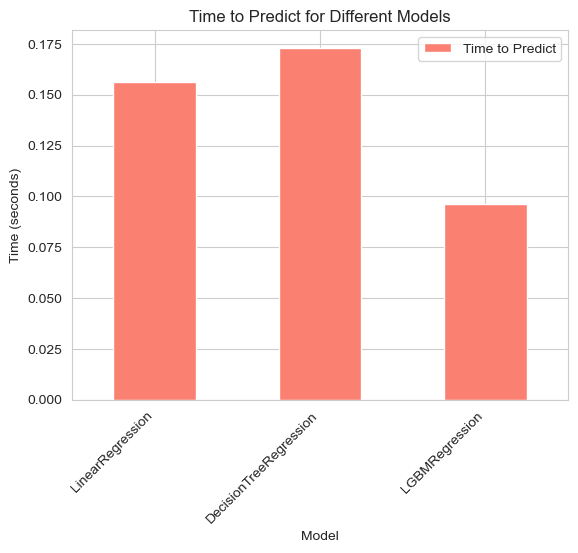

<Figure size 1000x600 with 0 Axes>

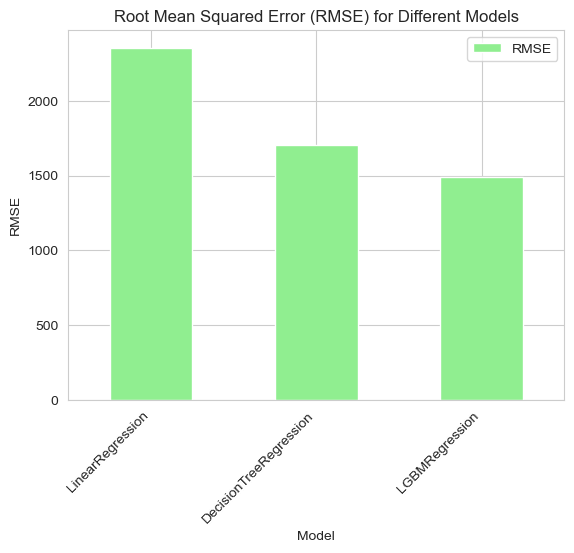

In [38]:
plt.figure(figsize=(10, 6))
mdata.plot.bar(x='Model', y='Time to Fit', color='skyblue')
plt.title('Time to Fit for Different Models')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha="right")
plt.show()

# Plot Time to Predict
plt.figure(figsize=(10, 6))
mdata.plot.bar(x='Model', y='Time to Predict', color='salmon')
plt.title('Time to Predict for Different Models')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha="right")
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
mdata.plot.bar(x='Model', y='RMSE', color='lightgreen')
plt.title('Root Mean Squared Error (RMSE) for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha="right")
plt.show()

Comparing LGBM model with other you can see by the time and resualts that gradient boosting is faster and more accurate to get predictions.
Interesting to see that DecisionTreeRegressor is slower to fit comparing to LinearRegressor and LGBMRegressor.